# Predicting Bike Rentals

## Project

Imagine how important it is for a bike-sharing company to know how many bikes it needs. If there are not enough of them, it loses potential clients. If there are more than are actually needed, they just stay and generate costs. I'm going to help solve this problem by predicting these numbers.

I will work on a real data collected by such a company. I am going to use a neural network and code it myself as this will be a simple network with one hidden layer. At last I will tune the hyperparameters and compare the results.

## Import resources

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load the data

I'm going to work with data collected every hour. Let's load it and see its structure. 

In [2]:
DATA_PATH = 'data/hour.csv'

rides = pd.read_csv(DATA_PATH)
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


As you can see there are a few types of information. There is information whether a day is a working day, weekend or holiday. Bike usage depends on the weather and there are a few variables measuring the weather conditions. Finally, there is the number of rentals on a given hour. I am interested in a total count `cnt` without distinction between casual and registered rides.

## Explore the data

Now I'm going to plot the count hour by hour to see the pattern.

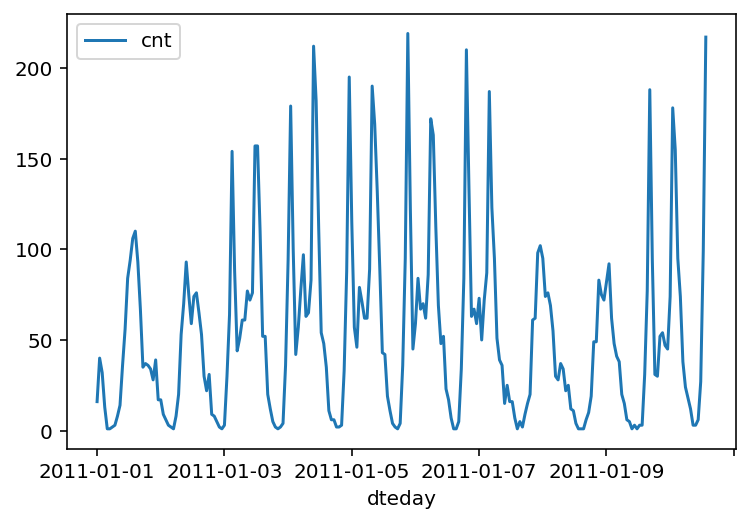

In [3]:
rides[:24*10].plot(x='dteday', y='cnt')

You can see the peaks and downs during the day. There are also peaks on working days and downs on weekends. This patterns are called seasonality and are typical to time-series data.

## Pre-processing the data

### Categorical variables

Although all variables are encoded with numbers, some of them like `weekday` are not numerical. E.g. `weekday `value of 5.6 would not make sense. Its value should be 0, 1, 2 etc. I'm going to convert them into binary ones.

In [4]:
dummy_variables = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_variables:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling variables

Let's standardize numerical variables. It will make training the model easier.

I'm going to save the original means and standard deviations, so I can convert them back. It is going to be useful when you will want to interpret the predicted values.

In [5]:
numerical_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

# Store scalings in a dictionary
scaled_features = {}

for each in numerical_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Split the data into training, validation and test sets

The test set will contain the last 21 days, I will use all remaining days for training the network.

In [6]:
# Save the last 21 days for testing
test_data = data[-21*24:]

# Remove the testing data from the dataset 
data = data[:-21*24]

# Split the data into features and target variables
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis = 1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis = 1), test_data[target_fields]

Now let's split the remaining data. I am going to use the last 60 days for validation, the rest will be used for training.

In [7]:
# Take the last 60 days out of the reamining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

It will be useful for monitoring the overfitting. Test error will always continue to drop while validation error doesn't have to. The latter will continue to drop only as long as the model is not overfitted.

## Build the network

I am going to build a simple neural network of 3 layers. There will be input, hidden and output layer.

You can easily tell the number of input nodes by looking at the number of features. There will be 56 input nodes, each one for each feature.

The number of hidden nodes will be set as a parameter so you can tune it later. I am going to use sigmoid activation function in this layer.

There will be one output node as I want to predict one variable (total number of rides on a given day). I am going to use a very simple activation function, f(x) = x. There is no need to transform the predicted value with a function like sigmoid. It is a regression problem and you are interested in an actual value.

In [8]:
# The implementation is in neural_network.py
# Here I am only importing the implemented model
from neural_network import NeuralNetwork

## Unit tests

Here is a bunch of unit tests to check if the network is implemented correctly.

I also define Mean Square Error which is needed for the tests.

In [9]:
def MSE(y, Y):
    return np.mean((y-Y) ** 2)

In [10]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(DATA_PATH.lower() == 'data/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.003s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Here I will train the network and experiment with hyperparameters. I'm going to change the parameters on the bottom of `neural_network.py` file and each time run the training code below. You want to find the parameters that result in a low training loss but also a low validation loss so there is no overfitting. 

### Number of iterations

When training you will notice that network reaches the optimum value and after this, the loss doesn't lower anymore. I want to set the number of iterations so the training stops shortly after reaching this value.

### Learning rate

High learning rate means that the network will have problem with reaching the minimum loss. On the other hand, low learning rate means that update in each iteration is tiny and the model needs a lot of iterations.

Normally, a good starting point is 0.1. If the weight update is divided by number of observations like I did here, you can start with 1. If the network has problems with fitting the data, you want to decrease this value.

### Number of hidden nodes

If the number of nodes is too low, the network will not have enough space to learn and predictions will not be as accurate as they could be. If there are too many nodes, the model will overfit.

The golden rule is to start with a value between the number of input nodes (56) and output nodes (1), preferably the mean (28). It should not exceed twice the number of input nodes.

In [11]:
import sys

####################
### Hyperparameters are set in neural_network.py file ###
####################

from neural_network import iterations, learning_rate, hidden_nodes, output_nodes


n_features = train_features.shape[1]
network = NeuralNetwork(n_features, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size = 128)
    X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']
                             
    network.train(X, y)
    
    # Print out the training progress
    train_loss = MSE(network.run(train_features.values).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features.values).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.076 ... Validation loss: 0.152

After trial and error, I have found the optimal parameters to be:
* iterations = 5000
* learning_rate = 0.4
* hidden_nodes = 7
* output_nodes = 1

They result in a pretty low losses after training. Let's see how they changed on a plot.

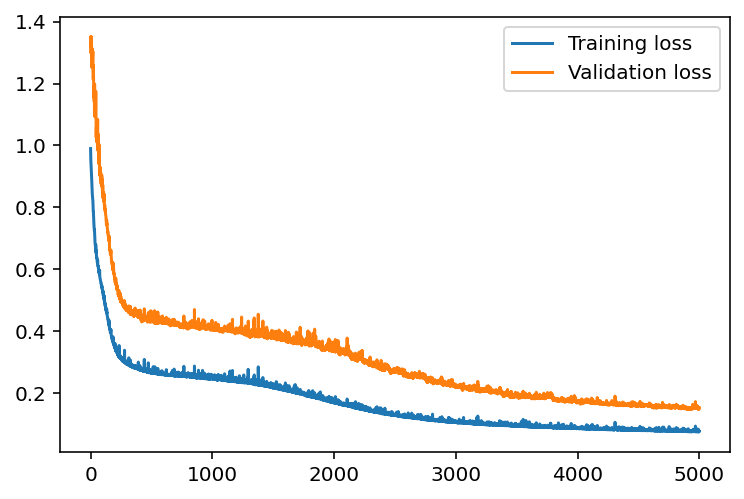

In [12]:
plt.plot(losses['train'], label = 'Training loss')
plt.plot(losses['validation'], label = 'Validation loss')
plt.legend()
_ = plt.ylim()

The curves are quite close to each other which indicates that there is no overfitting.

## Check predictions

Let's use the model the predict the bike rentals during the last 21 days. I want to see how they compare against the real rental values.

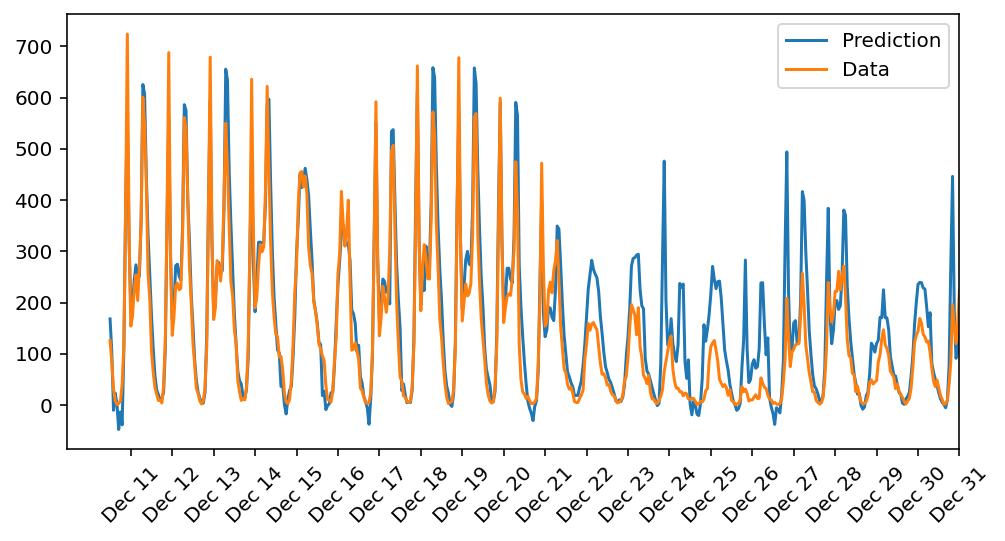

In [13]:
fig, ax = plt.subplots(figsize = (8, 4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features.values).T * std + mean
ax.plot(predictions[0], label = 'Prediction')
ax.plot((test_targets['cnt'] * std + mean).values, label = 'Data')
ax.set_xlim(right = len(predictions))
ax.legend()

dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation = 45)

I can see that the model predicts rides well between regular days like 11th - 22nd December. You can tell it because prediction and data curves interpolate during this period. However, between 23rd and 31st December the model is off with its prediction. It is understandable as these days are holiday days. Probably if the model was trained using data from a period of a few years, it would also learn the pattern during christmas holidays.

To recap, you can expect that the model will perform well with its prediction on regular days.